In [29]:
import geopandas as gpd
import pandas as pd
from scipy.stats import norm 
import numpy as np
from shapely.geometry import Polygon
import string
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import fowlkes_mallows_score, rand_score, mutual_info_score
import matplotlib.pyplot as plt
import os

In [30]:
zones = gpd.read_file("../data/processed_data/zones_delineation/PC_Leiden.gpkg")

In [31]:
zones.area.median()

2043.7616624030316

In [32]:
if not os.path.isfile('../data/toy_example/example_review.csv'):
    households_data = pd.read_csv('../data/toy_example/toy_example_base.csv', names= list(range(0,27)))
    households_data = households_data.applymap(lambda x: x + norm.rvs(loc = 0, scale = 0.5))
    households_data = households_data.applymap(lambda x: 1 if x>0.5 else 0)
else: 
    households_data = pd.read_csv('../data/toy_example/example_review.csv')
    households_data.columns = households_data.columns.astype(int)

In [33]:
# Making an alphabetical index for the city.
list_char=list(string.ascii_uppercase)
alphabet=list_char+[x+y for x in list_char for y in list_char]
name_columns_1 = alphabet[0:13]
# name_columns_2 = [sub + '_2' for sub in alphabet[0:13]]

In [34]:
city_1 = pd.DataFrame(data = [[np.mean(households_data.loc[2*i:2*i+1,2*j:2*j+1].mean().mean()) for i in range(13)] for j in range(13)],
                      columns = name_columns_1,
                      index = name_columns_1)
                      
city_2 = pd.DataFrame(data = [[np.mean(households_data.loc[2*i+1:2*i+2,2*j+1:2*j+2].mean().mean()) for i in range(13)] for j in range(13)],
                      columns = name_columns_1,
                      index = name_columns_1)
                      #columns = name_columns_2,
                      #index = name_columns_2)

In [35]:
def compute_res_mix(city_mix):
    res_mix = city_mix.T.stack().reset_index()
    res_mix = res_mix.rename(columns = {0:'res_mix'})
    res_mix['polygon_id'] = res_mix['level_0'] + '_' + res_mix['level_1']
    res_mix = res_mix.drop(columns = ['level_0','level_1'])
    return res_mix

In [36]:
# Generation of a grid.
def create_grid_geometry(city_mix, size_cell, name_columns):

    N_rows = len(city_mix)
    polygons = []
    polygon_id = []

    for x in range(N_rows):
        for y in range(N_rows):
            polygons.append(Polygon([(size_cell*x,size_cell*y), 
                                    (size_cell*(x+1), size_cell*y), 
                                    (size_cell*(x+1), size_cell*(y+1)),
                                    (size_cell*x, size_cell*(y+1))]))
            polygon_id.append(name_columns[x] + '_' + name_columns[y])

    grid = gpd.GeoDataFrame({'polygon_id':polygon_id,'geometry':polygons})
    
    centroids = grid.copy()
    centroids['geometry'] = grid.centroid

    return grid, centroids

In [37]:
def compute_shortest_paths(res_mix,size_cell, grid):
    # Computing the shortest paths from cell to cell.
    shortest_paths = pd.DataFrame({'from_polygon':[],'to_polygon':[],'distance':[]})

    for i in res_mix['polygon_id']:
        shortest_paths_i = pd.DataFrame({'from_polygon':[i]*len(res_mix),
                                         'to_polygon':res_mix['polygon_id'],
                                         'distance':grid.distance(grid.loc[res_mix['polygon_id'] == i,'geometry'].values[0])})
        shortest_paths = pd.concat([shortest_paths,shortest_paths_i], ignore_index=True)
    
    shortest_paths['weight'] = 1/(0.3*size_cell*0.707)**2
    shortest_paths['weight'] = shortest_paths['weight'].mask(shortest_paths['distance'] > 0,
                                                             1/(0.3*shortest_paths['distance'])**2)

    return shortest_paths

In [38]:
def compute_exposure(res_mix, grid, shortest_paths):

    exposure = res_mix.merge(shortest_paths[['from_polygon','to_polygon','weight']], 
                             left_on = 'polygon_id',
                             right_on = 'from_polygon')
    exposure = exposure.drop(columns = ['from_polygon','polygon_id'])
    exposure = exposure.rename(columns = {'to_polygon':'polygon_id'})
    exposure['exposure'] = exposure['res_mix']*exposure['weight']
    exposure = exposure[['polygon_id','weight','exposure']].groupby(by = 'polygon_id').sum().reset_index()
    exposure['exposure'] = exposure['exposure'] / exposure['weight']

    exposure = exposure.merge(res_mix, on ='polygon_id')

    return exposure

In [39]:
res_mix_1 = compute_res_mix(city_1)
grid, centroids = create_grid_geometry(city_1, 3, name_columns_1)
shortest_paths = compute_shortest_paths(res_mix_1, 3,centroids)
exposure_1 = compute_exposure(res_mix_1, centroids, shortest_paths)
res_mix_2 = compute_res_mix(city_2)
exposure_2 = compute_exposure(res_mix_2, centroids, shortest_paths)

In [40]:
exposure_1 = exposure_1.add_suffix('_1').rename(columns = {'polygon_id_1':'polygon_id'})
exposure_2 = exposure_2.add_suffix('_2').rename(columns = {'polygon_id_2':'polygon_id'})

In [41]:
grid_1 = grid.merge(exposure_1[['polygon_id','exposure_1','res_mix_1']], on = 'polygon_id')
grid_2 = grid.merge(exposure_2[['polygon_id','exposure_2','res_mix_2']], on = 'polygon_id')
grid_2['geometry'] = grid_2['geometry'].translate(1.5,1.5)

In [42]:
name_columns_hh_data = alphabet[0:27]
city_benchmark = pd.DataFrame(data = households_data,
                              columns = name_columns_hh_data,
                              index = name_columns_hh_data)

In [43]:
households_data.index = households_data.index.astype(str)
households_data.columns = households_data.columns.astype(str)
res_mix_hh_data = compute_res_mix(households_data)
grid_hh_data, centroids_hh_data = create_grid_geometry(households_data, 1.5,list(households_data.index))
shortest_paths_hh_data = compute_shortest_paths(res_mix_hh_data,1.5 ,centroids_hh_data)
exposure_hh_data = compute_exposure(res_mix_hh_data, centroids_hh_data, shortest_paths_hh_data)

In [44]:
grid_hh_data = grid_hh_data.merge(exposure_hh_data[['polygon_id','exposure','res_mix']], on = 'polygon_id')

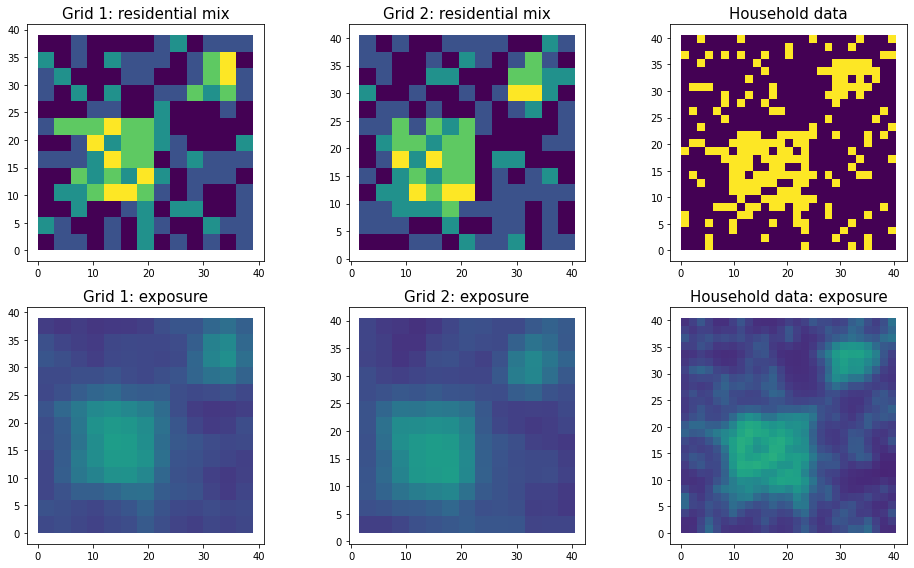

In [45]:
fig, ax = plt.subplots(2,3,figsize=(16, 8))
fig.set_tight_layout(True)

# Grid 1
grid_1.plot(ax=ax[0,0], column = 'res_mix_1', vmin = 0, vmax = 1)
grid_1.plot(ax=ax[1,0], column = 'exposure_1', vmin = 0, vmax = 1)

# Grid 2
grid_2.plot(ax=ax[0,1], column = 'res_mix_2', vmin = 0, vmax = 1)
grid_2.plot(ax=ax[1,1], column = 'exposure_2', vmin = 0, vmax = 1)

# Fine grid 
grid_hh_data.plot(ax=ax[0,2], column = 'res_mix', vmin = 0, vmax = 1)
grid_hh_data.plot(ax=ax[1,2], column = 'exposure', vmin = 0, vmax = 1)

# Set titles
ax[0,0].set_title('Grid 1: residential mix', size = 15)
ax[0,1].set_title('Grid 2: residential mix', size = 15)
ax[0,2].set_title('Household data', size = 15)
ax[1,0].set_title('Grid 1: exposure', size = 15)
ax[1,1].set_title('Grid 2: exposure', size = 15)
ax[1,2].set_title('Household data: exposure', size = 15)
plt.show()

In [46]:
def compute_adjacency_matrix(shortest_paths, grid, size_cell):

    adjacent_units = shortest_paths[['from_polygon','to_polygon','distance']]
    adjacent_units['adj'] = 0
    adjacent_units['adj'] = adjacent_units['adj'].mask((adjacent_units['distance'] > size_cell - 0.000001) & 
                                                       (adjacent_units['distance'] < size_cell + 0.000001), 1)
    adjacency_matrix = adjacent_units[['from_polygon','to_polygon','adj']].pivot_table(index = 'from_polygon',
                                                                                       columns = 'to_polygon',
                                                                                       values = 'adj')
    adjacency_matrix = adjacency_matrix.reindex(index = grid['polygon_id'],
                                                columns = grid['polygon_id'])
    return adjacency_matrix

In [47]:
adjacency_matrix_1 = compute_adjacency_matrix(shortest_paths, grid_1, 3)
adjacency_matrix_2 = compute_adjacency_matrix(shortest_paths, grid_2, 3)
adjacency_matrix_hh_data = compute_adjacency_matrix(shortest_paths_hh_data, grid_hh_data, 1.5)

In [48]:
def regionalization(grid, cluster_variable, adjacency_matrix, n_regions):

    X = np.array([grid.loc[:,cluster_variable]]).T
    clus_hh_data = AgglomerativeClustering(n_clusters = n_regions,
                                           connectivity = adjacency_matrix,
                                           linkage = 'ward').fit(X)

    grid['region_' + cluster_variable] = clus_hh_data.labels_
    
    return grid

In [49]:
def regionalization_var(grid, cluster_variable, adjacency_matrix, threshold):

    X = np.array([grid.loc[:,cluster_variable]]).T
    clus_hh_data = AgglomerativeClustering(n_clusters = None,
                                           distance_threshold=threshold,
                                           connectivity = adjacency_matrix,
                                           linkage = 'ward').fit(X)

    grid['region_' + cluster_variable] = clus_hh_data.labels_

    grid['count'] = 1    
    regions = grid[[cluster_variable,'region_' + cluster_variable,
                    'count','geometry']].dissolve(by = 'region_' + cluster_variable, aggfunc = 'sum')

    regions[cluster_variable] = regions[cluster_variable] / regions['count']
    regions = regions.drop(columns = 'count').reset_index()

    city_average = grid.loc[:,cluster_variable].mean()
    regions['seg_' + cluster_variable] = 0
    regions['seg_' + cluster_variable] = regions['seg_' + cluster_variable].mask(regions[cluster_variable] >= 1.1 * city_average,1)
    regions['seg_' + cluster_variable] = regions['seg_' + cluster_variable].mask(regions[cluster_variable] <= 0.9 * city_average,-1)

    grid = grid.sjoin(regions[['seg_' + cluster_variable,'geometry']],predicate = 'within').drop(columns = 'index_right')

    return grid

In [50]:
TSS_res_mix_1 = grid_1.res_mix_1.var()*len(grid_1)
TSS_res_mix_2 = grid_2.res_mix_2.var()*len(grid_2)
TSS_exposure_1 = grid_1.exposure_1.var()*len(grid_1)
TSS_exposure_2 = grid_2.exposure_2.var()*len(grid_2)
TSS_hh_data_exposure = grid_hh_data.exposure.var()*len(grid_hh_data)
TSS_hh_data_res_mix = grid_hh_data.res_mix.var()*len(grid_hh_data)

In [51]:
coef_treshold = 0.1
grid_1 = regionalization_var(grid_1, 'res_mix_1', adjacency_matrix_1,coef_treshold * np.sqrt(TSS_res_mix_1))
grid_2 = regionalization_var(grid_2, 'res_mix_2', adjacency_matrix_2,coef_treshold * np.sqrt(TSS_res_mix_2))
grid_1 = regionalization_var(grid_1, 'exposure_1', adjacency_matrix_1,coef_treshold * np.sqrt(TSS_exposure_1))
grid_2 = regionalization_var(grid_2, 'exposure_2', adjacency_matrix_2,coef_treshold * np.sqrt(TSS_exposure_2))
grid_hh_data = regionalization_var(grid_hh_data, 'exposure', adjacency_matrix_hh_data,coef_treshold * np.sqrt(TSS_hh_data_exposure))
grid_hh_data = regionalization_var(grid_hh_data, 'res_mix', adjacency_matrix_hh_data,coef_treshold * np.sqrt(TSS_hh_data_res_mix))

In [24]:
# N_regions = 3
# grid_1 = regionalization(grid_1, 'res_mix_1', adjacency_matrix_1,N_regions)
# grid_2 = regionalization(grid_2, 'res_mix_2', adjacency_matrix_2,N_regions)
# grid_1 = regionalization(grid_1, 'exposure_1', adjacency_matrix_1,N_regions)
# grid_2 = regionalization(grid_2, 'exposure_2', adjacency_matrix_2,N_regions)
# grid_hh_data = regionalization(grid_hh_data, 'exposure', adjacency_matrix_hh_data,N_regions)
# grid_hh_data = regionalization(grid_hh_data, 'res_mix', adjacency_matrix_hh_data,N_regions)

In [25]:
result_1 = grid_hh_data.sjoin(grid_1[['res_mix_1','exposure_1','region_res_mix_1','region_exposure_1','geometry']], 
                              predicate = 'within').drop(columns = 'index_right')
result_2 = grid_hh_data.sjoin(grid_2[['res_mix_2','exposure_2','region_res_mix_2','region_exposure_2','geometry']], 
                              predicate = 'within').drop(columns = 'index_right')
result_comp = result_1.sjoin(grid_2[['res_mix_2','exposure_2','region_res_mix_2','region_exposure_2','geometry']], 
                             predicate = 'within').drop(columns = 'index_right')

In [50]:
result_1['count'] = 1
city_average = result_1['res_mix_1'].mean()
region_res_mix_1 = result_1[['res_mix_1','region_res_mix_1',
                             'count','geometry']].dissolve(by = 'region_res_mix_1', aggfunc = 'sum')
region_res_mix_1['res_mix_1'] = region_res_mix_1['res_mix_1'] / region_res_mix_1['count']
region_res_mix_1 = region_res_mix_1.drop(columns = 'count').reset_index()
region_res_mix_1['seg'] = 0
region_res_mix_1['seg'] = region_res_mix_1['seg'].mask(region_res_mix_1['res_mix_1'] >= 1.1 * city_average,1)
region_res_mix_1['seg'] = region_res_mix_1['seg'].mask(region_res_mix_1['res_mix_1'] <= 0.1 * city_average,-1)

<AxesSubplot:>

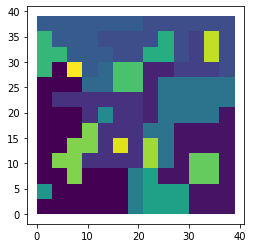

In [52]:
region_res_mix_1.plot('region_res_mix_1')

<AxesSubplot:>

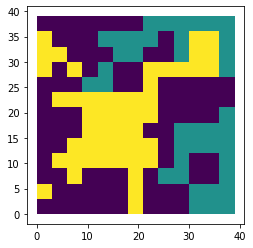

In [51]:
region_res_mix_1.plot('seg')

In [26]:
region_res_mix_1 = result_1.dissolve(by = 'region_res_mix_1')
region_exposure_1 = result_1.dissolve(by = 'region_exposure_1')

region_exposure_2 = result_2.dissolve(by = 'region_exposure_2')
region_res_mix_2 = result_2.dissolve(by = 'region_res_mix_2')

region_benchmark_exposure = grid_hh_data.dissolve(by = 'region_exposure')
region_benchmark_res_mix = grid_hh_data.dissolve(by = 'region_res_mix')
# Benchmark in grid 1.
region_benchmark_res_mix_1 = result_1.dissolve(by = 'region_res_mix')
region_benchmark_exposure_1 = result_1.dissolve(by = 'region_exposure')
# Benchmark, in grid 2.
region_benchmark_res_mix_2 = result_2.dissolve(by = 'region_res_mix')
region_benchmark_exposure_2 = result_2.dissolve(by = 'region_exposure')
# Benchmark, in comp
region_exposure_comp_1 = result_comp.dissolve(by = 'region_exposure_1')
region_res_mix_comp_1 = result_comp.dissolve(by = 'region_res_mix_1')
region_exposure_comp_2 = result_comp.dissolve(by = 'region_exposure_2')
region_res_mix_comp_2 = result_comp.dissolve(by = 'region_res_mix_2')

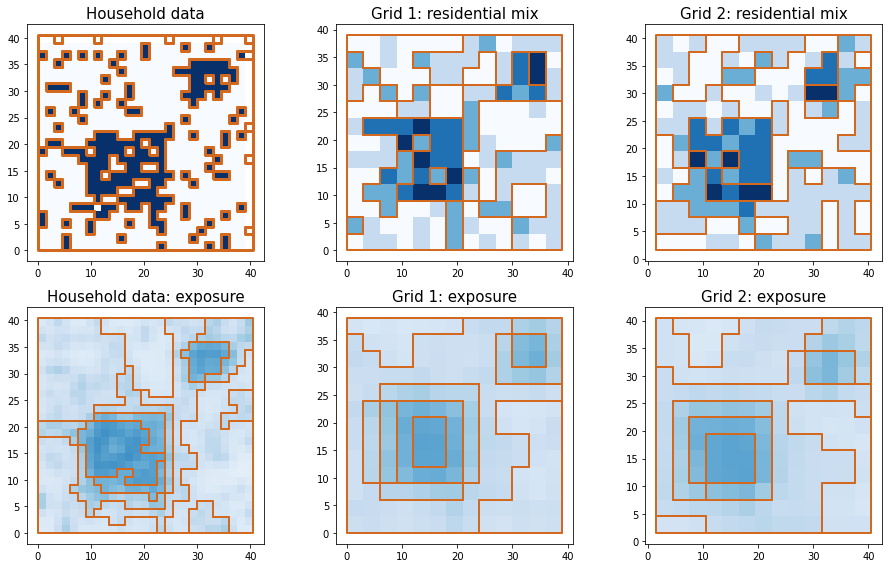

In [27]:
fig, ax = plt.subplots(2,3,figsize=(16, 8))
fig.set_tight_layout(True)

# Fine grid 
result_1.plot(ax=ax[0,0], cmap = 'Blues', column = 'res_mix', vmin = 0, vmax = 1)
region_benchmark_res_mix.plot(ax=ax[0,0], color  = 'none', edgecolor='chocolate', linewidth = 3)
grid_hh_data.plot(ax=ax[1,0], cmap = 'Blues', column = 'exposure', vmin = 0, vmax = 1)
region_benchmark_exposure.plot(ax=ax[1,0], color  = 'none', edgecolor='chocolate', linewidth = 2)


# Grid 1
result_1.plot(ax=ax[0,1], cmap = 'Blues',column = 'res_mix_1', vmin = 0, vmax = 1)
region_res_mix_1.plot(ax=ax[0,1], color  = 'none', edgecolor='chocolate', linewidth = 2)
result_1.plot(ax=ax[1,1], cmap = 'Blues', column = 'exposure_1', vmin = 0, vmax = 1)
region_exposure_1.plot(ax=ax[1,1], color  = 'none', edgecolor='chocolate', linewidth = 2)


# Grid 2
result_2.plot(ax=ax[0,2], cmap = 'Blues', column = 'res_mix_2', vmin = 0, vmax = 1)
region_res_mix_2.plot(ax=ax[0,2], color  = 'none', edgecolor='chocolate', linewidth = 2)
result_2.plot(ax=ax[1,2], cmap = 'Blues', column = 'exposure_2', vmin = 0, vmax = 1)
region_exposure_2.plot(ax=ax[1,2], color  = 'none', edgecolor='chocolate', linewidth = 2)

# Set titles
ax[0,1].set_title('Grid 1: residential mix', size = 15)
ax[0,2].set_title('Grid 2: residential mix', size = 15)
ax[0,0].set_title('Household data', size = 15)
ax[1,1].set_title('Grid 1: exposure', size = 15)
ax[1,2].set_title('Grid 2: exposure', size = 15)
ax[1,0].set_title('Household data: exposure', size = 15)
plt.show()

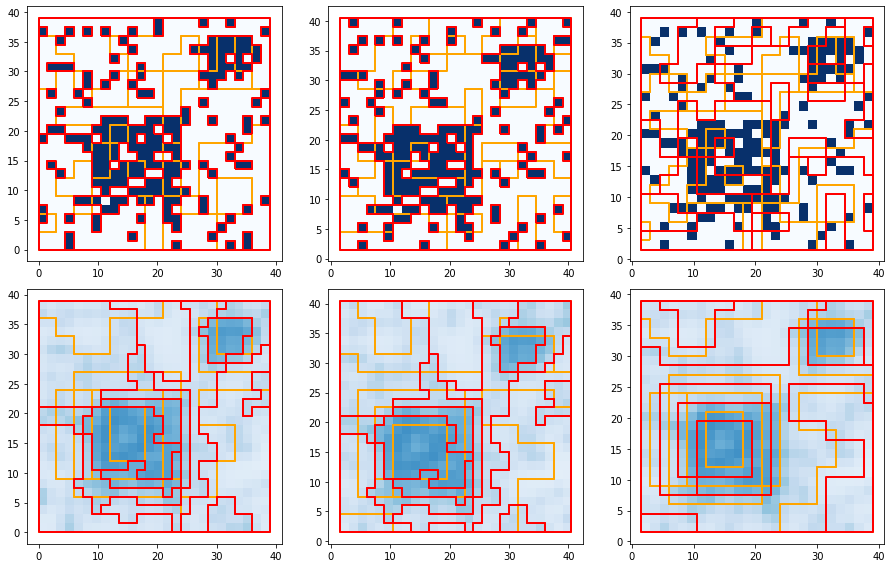

In [28]:
fig, ax = plt.subplots(2,3,figsize=(16, 8))
fig.set_tight_layout(True)


result_1.plot(ax=ax[0,0], cmap = 'Blues',column = 'res_mix', vmin = 0, vmax = 1)
region_res_mix_1.plot(ax=ax[0,0], color  = 'none', edgecolor='orange', linewidth = 2)
region_benchmark_res_mix_1.plot(ax=ax[0,0], color  = 'none', edgecolor='red', linewidth = 2)

result_2.plot(ax=ax[0,1], cmap = 'Blues',column = 'res_mix', vmin = 0, vmax = 1)
region_res_mix_2.plot(ax=ax[0,1], color  = 'none', edgecolor='orange', linewidth = 2)
region_benchmark_res_mix_2.plot(ax=ax[0,1], color  = 'none', edgecolor='red', linewidth = 2)

result_1.plot(ax=ax[1,0], cmap = 'Blues',column = 'exposure', vmin = 0, vmax = 1)
region_exposure_1.plot(ax=ax[1,0], color  = 'none', edgecolor='orange', linewidth = 2)
region_benchmark_exposure_1.plot(ax=ax[1,0], color  = 'none', edgecolor='red', linewidth = 2)

result_2.plot(ax=ax[1,1], cmap = 'Blues',column = 'exposure', vmin = 0, vmax = 1)
region_exposure_2.plot(ax=ax[1,1], color  = 'none', edgecolor='orange', linewidth = 2)
region_benchmark_exposure_2.plot(ax=ax[1,1], color  = 'none', edgecolor='red', linewidth = 2)

result_comp.plot(ax=ax[0,2], cmap = 'Blues',column = 'res_mix', vmin = 0, vmax = 1)
region_res_mix_comp_1.plot(ax=ax[0,2], color  = 'none', edgecolor='orange', linewidth = 2)
region_res_mix_comp_2.plot(ax=ax[0,2], color  = 'none', edgecolor='red', linewidth = 2)

result_comp.plot(ax=ax[1,2], cmap = 'Blues',column = 'exposure', vmin = 0, vmax = 1)
region_exposure_comp_1.plot(ax=ax[1,2], color  = 'none', edgecolor='orange', linewidth = 2)
region_exposure_comp_2.plot(ax=ax[1,2], color  = 'none', edgecolor='red', linewidth = 2)


plt.show()

In [29]:
def compute_metrics(labels_true, labels_pred):

    metrics = pd.DataFrame({'fowlkes_mallows':[fowlkes_mallows_score(labels_true,labels_pred)],
                            'rand':[rand_score(labels_true,labels_pred)],
                            'mutual_info':[mutual_info_score(labels_true,labels_pred)]})
    return metrics

In [30]:
compute_metrics(result_1['region_res_mix'], result_1['region_res_mix_1'])

,fowlkes_mallows,rand,mutual_info
0,0.254915,0.5189,0.610152


In [31]:
compute_metrics(result_1['region_exposure'], result_1['region_exposure_1'])

,fowlkes_mallows,rand,mutual_info
0,0.352762,0.786198,1.063335


In [32]:
compute_metrics(result_2['region_res_mix'], result_2['region_res_mix_2'])

,fowlkes_mallows,rand,mutual_info
0,0.25002,0.521442,0.651799


In [33]:
compute_metrics(result_2['region_exposure'], result_2['region_exposure_2'])

,fowlkes_mallows,rand,mutual_info
0,0.326539,0.801631,1.040566


In [34]:
compute_metrics(result_comp['region_res_mix_1'], result_comp['region_res_mix_2'])

,fowlkes_mallows,rand,mutual_info
0,0.306539,0.878277,1.443469


In [35]:
compute_metrics(result_comp['region_exposure_1'], result_comp['region_exposure_2'])

,fowlkes_mallows,rand,mutual_info
0,0.442208,0.785241,1.018229


What remains to be done:
- Compute regions in the benchmark
- Compute regions in the exposure
- Compare
- Compute the exposure with the fine scale data and compare